In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
from tqdm import tqdm
from scipy import stats
import networkx as nx
import seaborn as sns
import re
import sys
sys.path.append("../scripts/")
from nn import *
from train_new_subset_classes import *
from data_utils import *

plt.style.use("../config/custom_plt.mplstyle")
plt.rc('text', usetex=False)

In [2]:
%%time 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = 'MNIST'

# home/rjankow/data/multiple_runs/output_mnist_{h[0]}_i{i}/

# res = train_mlp(classes_to_select=[0, 1, 7],
#                   device=device,
#                   hidden_sizes=[128],
#                   is_save_graph=False,
#                   output_path=f'',
#                   verbose=True)

CPU times: user 35 μs, sys: 1 μs, total: 36 μs
Wall time: 46.5 μs


In [3]:
import torch
import random
from skimage.metrics import structural_similarity as ssim
import cv2

def binarize_image(img, threshold=0.0):
    """
    Convert a single image tensor (1, 28, 28) to a binary tensor {0,1}.
    Assumes pixel values are in [-1,1] or [0,1].
    Adjust threshold as needed.
    """
    return (img > threshold).float()

def hamming_distance(img1, img2):
    """
    Compute the Hamming distance between two binarized images.
    Both img1, img2 should be shape (1, 28, 28) or (28, 28).
    """
    flat1 = img1.view(-1)
    flat2 = img2.view(-1)
    return (flat1 != flat2).sum().item()  # Number of differing pixels


def euclidean_distance(img1, img2):
    """
    Compute the L2 (Euclidean) distance between two images (float tensors).
    Assumes each img is shape (1, 28, 28) for MNIST, or (C, H, W) in general.
    """
    # Flatten the images into 1-D vectors
    diff = (img1 - img2).view(-1)
    return torch.sqrt(torch.sum(diff ** 2)).item()


def ssim_metric(img1, img2):
    """
    Compute the Structural Similarity (SSIM) between two single-channel images.
    
    Args:
      img1, img2: PyTorch tensors of shape (1, H, W) or (H, W) for MNIST-like data.
                  Typically in range [0,1] or [-1,1], but SSIM can handle that 
                  if we set 'data_range' properly.
                  
    Returns:
      ssim_value: float in [0,1], where 1 indicates identical images.
    """
    # If shape is (1, H, W), remove the channel dimension
    arr1 = img1.squeeze().cpu().numpy()  # shape (H, W)
    arr2 = img2.squeeze().cpu().numpy()
    
    # data_range should be the difference between min and max pixel values
    # e.g., if images are in [0,1], data_range=1. 
    # If in [-1,1], data_range=2, etc. We'll compute dynamically:
    data_range = arr1.max() - arr1.min()
    # If max==min (completely blank image), data_range can be 0.0 => avoid that:
    if data_range == 0:
        data_range = 1.0
    
    # Compute SSIM
    ssim_val = ssim(arr1, arr2, data_range=data_range)
    return ssim_val


def ssim_distance(img1, img2):
    # If 0 -> identical images, 1 -> very different images
    return 1 - ssim_metric(img1, img2)

In [4]:
def collect_images_by_label(loader, max_per_class=20000, threshold=0.0):
    """
    Gather a subset of images from the loader, grouped by label.

    Args:
      loader: DataLoader of (image, label) pairs.
      max_per_class: maximum number of images to store per label.
      threshold: threshold for binarization (if your data is in [-1,1], threshold=0 might be good).

    Returns:
      dict: label -> list of binarized images
    """
    label2images = {}
    
    for batch_imgs, batch_labels in loader:
        for img, label in zip(batch_imgs, batch_labels):
            label = label.item()
            if label not in label2images:
                label2images[label] = []
            
            if len(label2images[label]) < max_per_class:
                #bin_img = binarize_image(img, threshold=threshold)
                label2images[label].append(img) # or bin_img
    
    return label2images

In [5]:
def average_intra_class_distance(label2images, label, n_pairs=10000):
    """
    Compute the average Hamming distance within a single class (label),
    sampling n_pairs random pairs from label2images[label].
    """
    images = label2images[label]
    num_imgs = len(images)
    if num_imgs < 2:
        return None  # Not enough images in this class

    total_dist = 0.0
    for _ in tqdm(range(n_pairs)):
        i1, i2 = random.sample(range(num_imgs), 2)
#         dist = hamming_distance(images[i1], images[i2])
#         dist = euclidean_distance(images[i1], images[i2])
        dist = ssim_distance(images[i1], images[i2])
    
        total_dist += dist
    
    avg_dist = total_dist / n_pairs
    return avg_dist


def average_inter_class_distance(label2images, labelA, labelB, n_pairs=10000):
    """
    Compute average Hamming distance for pairs of images
    coming from two different classes: labelA and labelB.
    """
    imagesA = label2images[labelA]
    imagesB = label2images[labelB]
    if len(imagesA) == 0 or len(imagesB) == 0:
        return None
    
    total_dist = 0.0
    for _ in tqdm(range(n_pairs)):
        iA = random.randrange(len(imagesA))
        iB = random.randrange(len(imagesB))
#         dist = hamming_distance(imagesA[iA], imagesB[iB])
#         dist = euclidean_distance(imagesA[iA], imagesB[iB])
        dist = ssim_distance(imagesA[iA], imagesB[iB])    
        total_dist += dist
    
    avg_dist = total_dist / n_pairs
    return avg_dist

In [6]:
classes_to_select = [0,1,2,3,4,5,6,7,8,9]

train_mnist, test_mnist = load_mnist_subset(classes_to_select=classes_to_select)
# train_mnist, test_mnist = load_optical_digits(classes_to_select=classes_to_select)

In [7]:
trainlabel2images = collect_images_by_label(train_mnist)

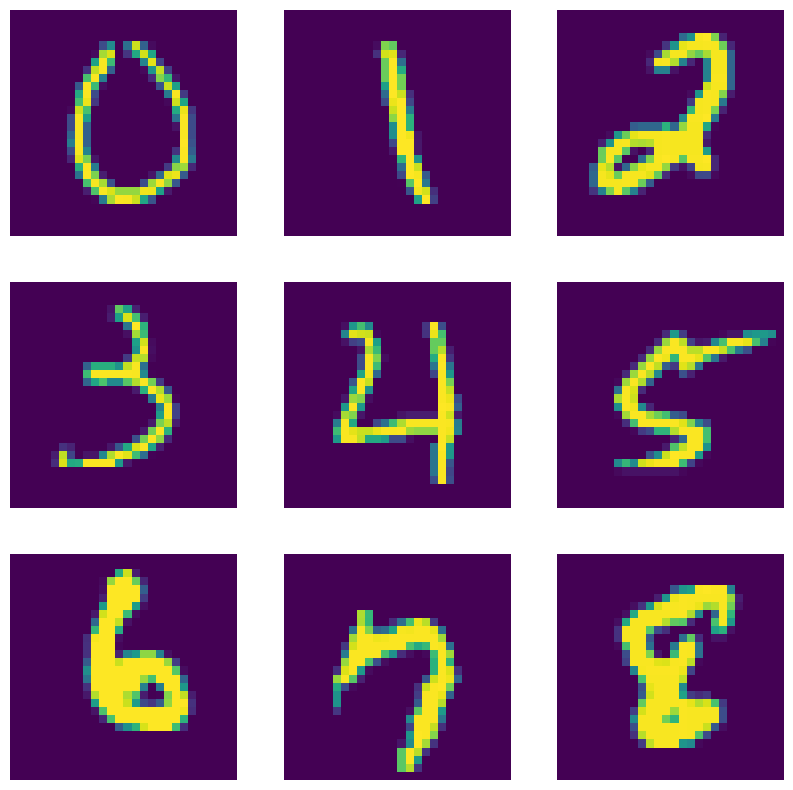

In [8]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(trainlabel2images[i][1].reshape(28,28))
    plt.axis('off')

In [9]:
intra_sim = []
for c in classes_to_select:
    intra_sim.append(average_intra_class_distance(trainlabel2images, c))

100%|██████████| 10000/10000 [00:01<00:00, 5926.84it/s]


Text(0.5, 0, 'Class')

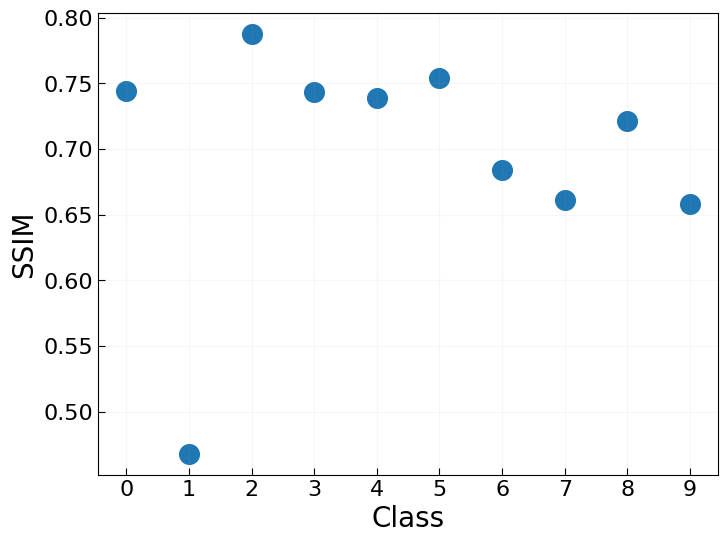

In [10]:
plt.scatter(classes_to_select, intra_sim, s=200)
plt.xticks(classes_to_select)
plt.ylabel('SSIM')
plt.xlabel('Class')

In [11]:
inter_sim = {}

for c1 in tqdm(classes_to_select):
    print(c1)
    for c2 in classes_to_select:
        if c1 == c2:
            continue
        inter_sim[(c1, c2)] = average_inter_class_distance(trainlabel2images, c1, c2)


  0%|          | 0/10 [00:00<?, ?it/s]

0



100%|██████████| 10000/10000 [00:01<00:00, 6161.61it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6658.45it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6586.83it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6556.52it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6959.81it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6895.42it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6352.29it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6365.29it/s][A

 10%|█         | 1/10 [00:13<02:04, 13.85s/it]

1



100%|██████████| 10000/10000 [00:01<00:00, 6604.63it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6340.48it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6018.94it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6704.12it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 5659.69it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6725.80it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6660.31it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6610.18it/s][A

 20%|██        | 2/10 [00:28<01:52, 14.09s/it]

2



100%|██████████| 10000/10000 [00:01<00:00, 6415.55it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6352.50it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6279.46it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 5997.75it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 5859.42it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6725.56it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6068.03it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 7230.31it/s][A

 30%|███       | 3/10 [00:42<01:39, 14.16s/it]

3



100%|██████████| 10000/10000 [00:01<00:00, 5677.45it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6141.04it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6479.68it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6922.75it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6869.61it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6400.62it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6640.31it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6465.62it/s][A

 40%|████      | 4/10 [00:56<01:24, 14.09s/it]

4



100%|██████████| 10000/10000 [00:01<00:00, 6629.16it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6663.31it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6028.97it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 5714.17it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 5513.76it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6683.20it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6657.20it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6314.87it/s][A

 50%|█████     | 5/10 [01:10<01:11, 14.21s/it]

5



100%|██████████| 10000/10000 [00:01<00:00, 5988.30it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 5970.31it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 5909.26it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6183.93it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 5730.44it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6671.30it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6528.65it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6159.93it/s][A

 60%|██████    | 6/10 [01:25<00:57, 14.34s/it]

6



100%|██████████| 10000/10000 [00:01<00:00, 6589.80it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6230.34it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6389.83it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 7300.68it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6446.49it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6255.32it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6714.26it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 5923.55it/s][A

 70%|███████   | 7/10 [01:39<00:42, 14.20s/it]

7



100%|██████████| 10000/10000 [00:01<00:00, 6660.09it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 5784.76it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6175.00it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6604.75it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 5712.13it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6168.38it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6764.71it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6138.86it/s][A

 87%|████████▋ | 8709/10000 [00:01<00:00, 6567.58it/s]


 80%|████████  | 8/10 [01:53<00:28, 14.29s/it]

8



100%|██████████| 10000/10000 [00:01<00:00, 6551.36it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6254.46it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 5993.01it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6536.56it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 5991.17it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6678.09it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 7114.78it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6282.49it/s][A

 90%|█████████ | 9/10 [02:07<00:14, 14.20s/it]

9



100%|██████████| 10000/10000 [00:01<00:00, 6733.62it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6700.17it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6733.92it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6247.53it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 7050.66it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6046.19it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6358.10it/s][A

100%|██████████| 10000/10000 [00:01<00:00, 6593.69it/s][A

100%|██████████| 10/10 [02:21<00:00, 14.15s/it]


Text(0.5, 1.0, 'MNIST')

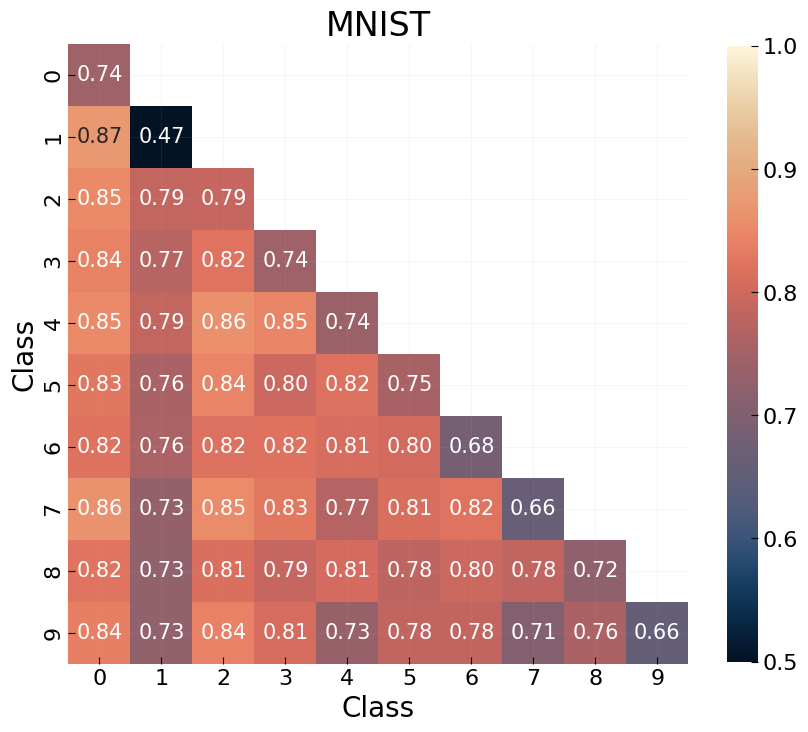

In [12]:
import cmcrameri
cmap      = cmcrameri.cm.lipari

matrix = np.zeros((10, 10))
for (i, j), value in inter_sim.items():
    matrix[i, j] = value
    
for c in classes_to_select:
    matrix[c, c] = intra_sim[c]

plt.figure(figsize=(10, 10))

mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True
mask[np.eye(mask.shape[0], dtype=bool)] = False
    
ax = sns.heatmap(matrix, annot=True, fmt=".2f", xticklabels=classes_to_select, cmap=cmap, vmin=0.5, vmax=1,
                 yticklabels=classes_to_select,square=True,mask=mask, annot_kws={"size": 15},
                 cbar_kws={"shrink": 0.8} )
plt.xlabel("Class")
plt.ylabel("Class")
plt.title("MNIST")

# plt.savefig("../plots/paper/ssim_mnist.pdf")

In [14]:
import pickle

with open("acc_shuffled_mlp_data.pickle", 'rb') as f:
    acc_shuffle_diff_mlp = pickle.load(f)

In [25]:
inter_sim

inter_sim_unique = {}
for (i, j), val in inter_sim.items():
    key = tuple(sorted((i, j)))  # makes (1,0) into (0,1)
    if key not in inter_sim_unique:
        inter_sim_unique[key] = val
    else:
        # Optional: average the values if both (i,j) and (j,i) exist
        inter_sim_unique[key] = (inter_sim_unique[key] + val) / 2

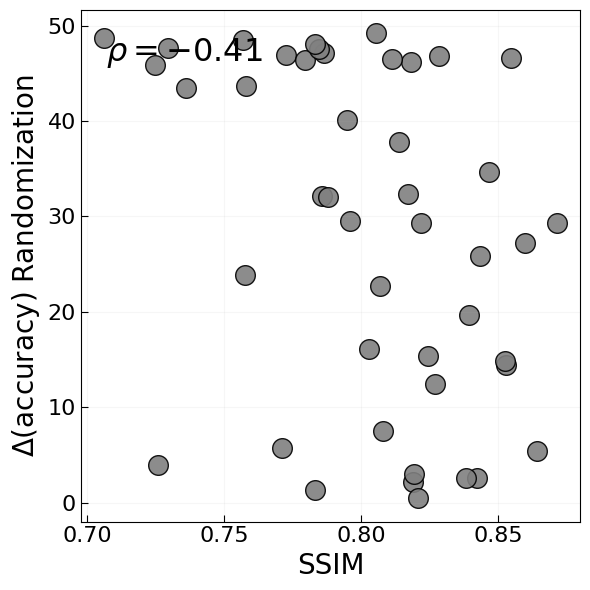

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

x = np.array(list(inter_sim_unique.values()))
y = np.array(list(acc_shuffle_diff_mlp.values()))

rho, pval = spearmanr(x, y)

plt.figure(figsize=(6, 6))
# plt.plot(np.linspace(0, 50), np.linspace(0, 50), linestyle='--', color='black')
plt.scatter(x, y, color='grey', alpha=0.9, s=200, edgecolor='black')

plt.ylabel(r'$\Delta$(accuracy) Randomization')
plt.xlabel(r'SSIM')

plt.text(
    0.05, 0.95,
    r'$\rho = {:.2f}$'.format(rho),
    transform=plt.gca().transAxes,
    ha='left', va='top',
    fontsize=23
)

plt.tight_layout()